In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline

In [2]:
df_train = pd.read_csv("train.csv")

In [3]:
print(df_train.head())
print(df_train.shape)

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008     

In [4]:
# Average overall quality is 6.1 and average overall condition is 5.6
# Check label: Average sale price is 181k, with the highest value of 755k and the lowest value of 79k
df_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


Think through and weigh features based on importance
Start with the following variables: 
OverallCond, LotArea, Neighborhood,YearBuilt, YearRemodAdd, GrLivArea, TotalBsmtSF, SaleCondition

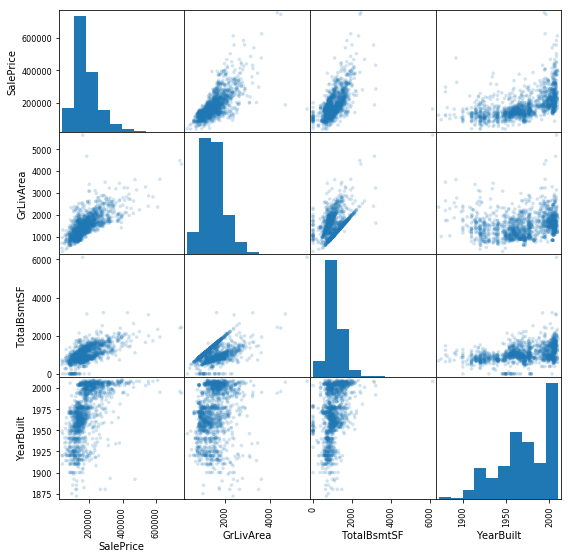

In [5]:
# Create Scatter Matrix, for numeric vars only
# Scatter Plot is good for showing relationships beteen numeric variables.
# Relationship between numeric and categorical vars is better shown with boxplot
from pandas.tools.plotting import scatter_matrix

KeyFeature = df_train[["SalePrice","GrLivArea","TotalBsmtSF","YearBuilt"]]
scatter = pd.plotting.scatter_matrix(KeyFeature, alpha=0.2, figsize=(9, 9), s=50)

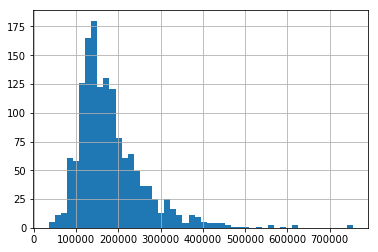

In [6]:
# Explore the label
df_train.SalePrice.hist(bins = 50)

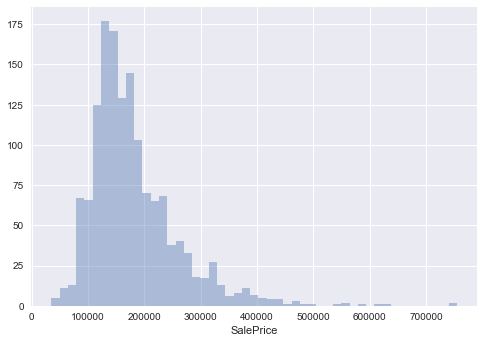

In [7]:
# The distribution of sale prices deviates from the normal distribution and positively skewed

import seaborn as sns
sns.distplot(df_train.SalePrice, kde = False)

In [8]:
# Skewness and Kurtosis
# Skewness is a measure of symmetry, or more precisely, the lack of symmetry. 
# A distribution, or data set, is symmetric if it looks the same to the left and right of the center point.at is, data sets with high kurtosis tend to have heavy tails, or outliers. Data sets with low kurtosis tend to have light tails, or lack of outliers. 
print("Skewness: %f" % df_train['SalePrice'].skew())

# Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution.
# That is, data sets with high kurtosis tend to have heavy tails, or outliers.
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


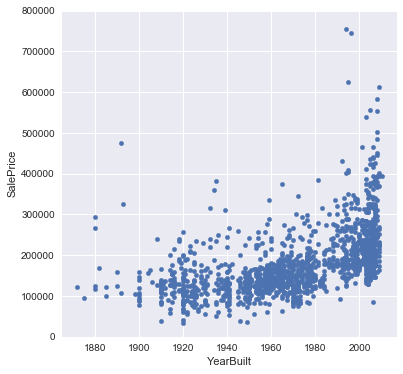

In [9]:
# Plot individual scatter plot
df_train.plot.scatter(x='YearBuilt', y='SalePrice', ylim=(0,800000),figsize=(6,6));

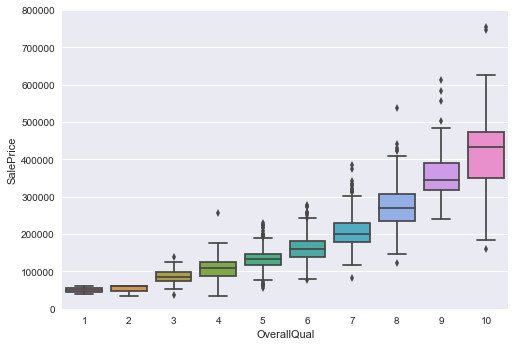

In [10]:
# Box plot
# f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='OverallQual', y="SalePrice", data=df_train)
fig.axis(ymin=0, ymax=800000);

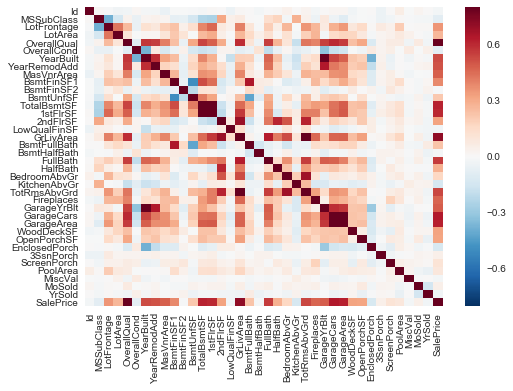

In [11]:
# More feature exploration/visualization
# !!Heatmap is the best way to get a quick overview of feature relationships
# Colored squares indicate multicollinearity

# Correlation matrix
corrmat = df_train.corr()
# f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=False);

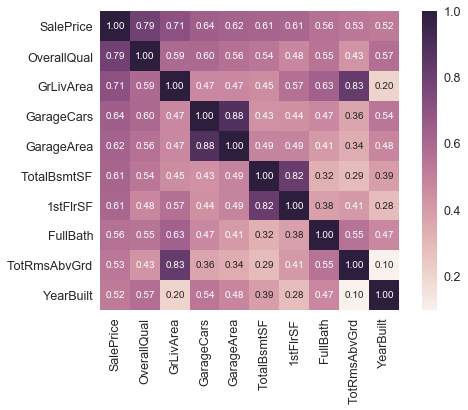

In [12]:
# saleprice correlation matrix (zoomed heat map)
k = 10 # number of variables for heatmap
cols = corrmat.nlargest(k,"SalePrice")['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
# plt.show()

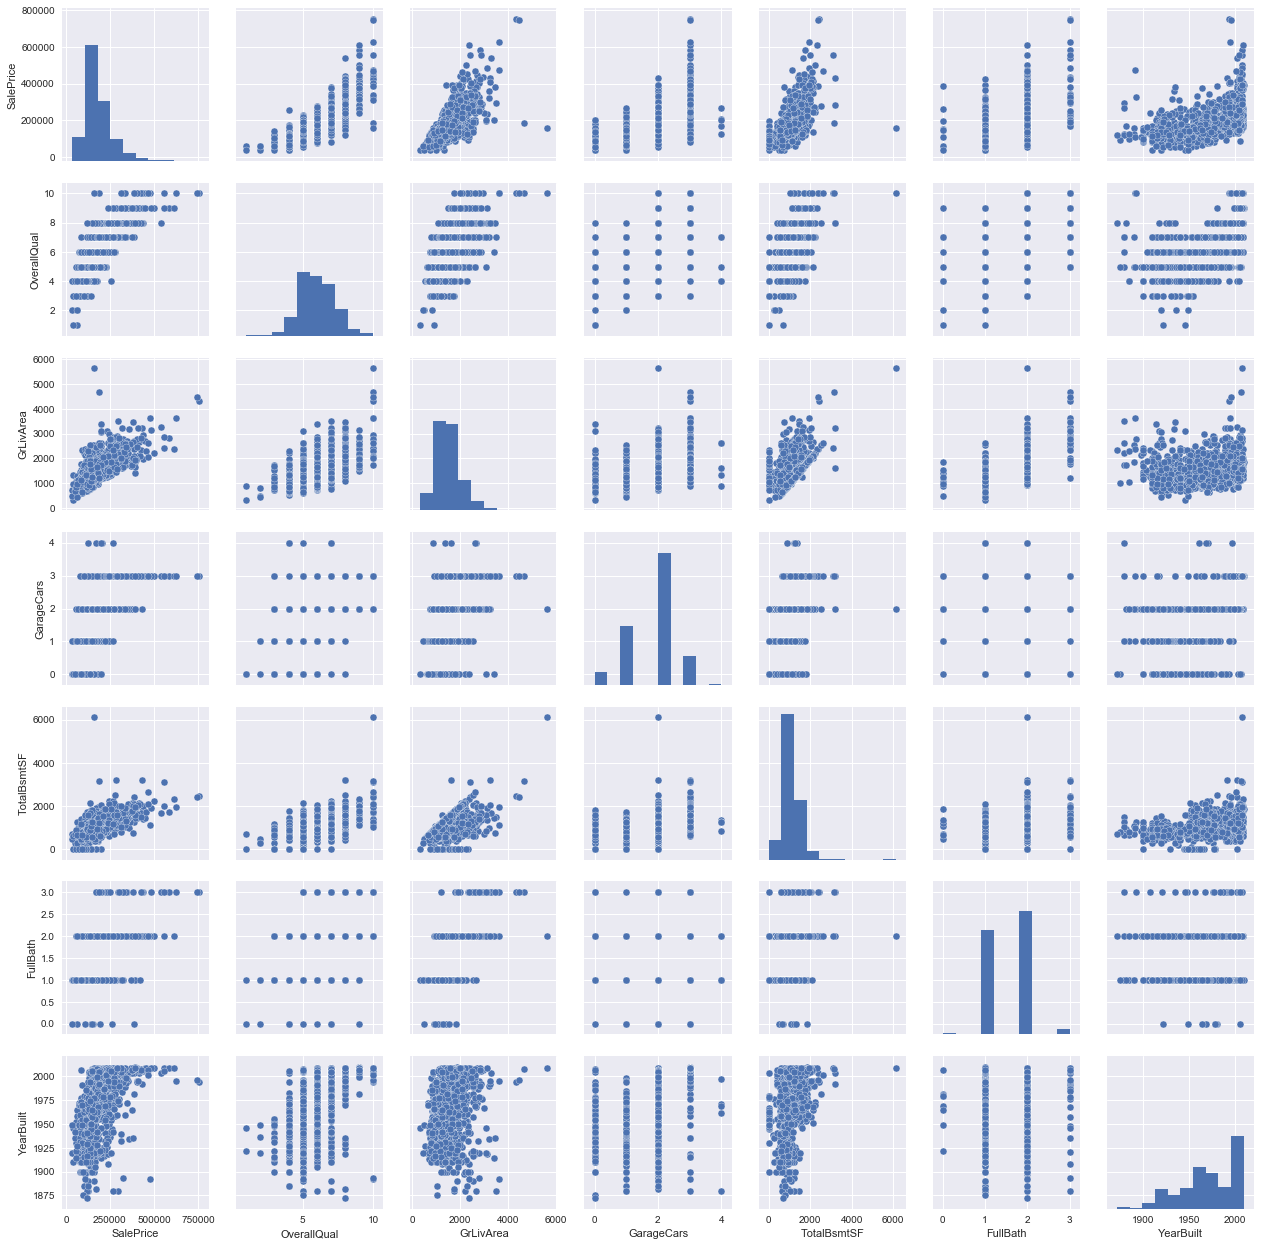

In [13]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], size = 2.5)
# plt.show();

## Missing Data

In [14]:
#missing data
total = df_train.isnull().sum().sort_values(ascending=False)
pct = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, pct], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [15]:
#dealing with missing data
# missing_data[missing_data['Total']>1].index
# df_train = df_train.drop(missing_data[missing_data['Total'] > 1].index,axis=1)
# # df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index, inplace = True)
# # df_train.isnull().sum().max() #just checking that there's no missing data missing...


## Outliers

In [16]:
# Based on eyeball test, get rid of a few outliers in the GrLivArea and TotalBsmtSF var;
df_train.GrLivArea.sort_values(ascending = False)
df_train = df_train[df_train.GrLivArea<=4500]

In [17]:
df_train.TotalBsmtSF.sort_values(ascending = False).head(10)

332     3206
496     3200
440     3094
1373    2633
1044    2524
691     2444
1182    2396
224     2392
898     2330
70      2223
Name: TotalBsmtSF, dtype: int64

## Preprocess features and label

In [18]:
# First check the label variable
from sklearn.preprocessing import StandardScaler
saleprice_scaled = StandardScaler().fit_transform(df_train['SalePrice'][:,np.newaxis]);
#  argsort() np sort array values
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10] 
print(low_range)
high_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:] 
print(high_range)

# Be careful about the high range, 7+ numbers. for now, do not treat them as outliers

[[-1.83763662]
 [-1.83246471]
 [-1.79988548]
 [-1.78226827]
 [-1.77345967]
 [-1.6224551 ]
 [-1.61616324]
 [-1.58470395]
 [-1.58470395]
 [-1.57220832]]
[[ 3.82629346]
 [ 4.03816547]
 [ 4.49323035]
 [ 4.7071535 ]
 [ 4.72704835]
 [ 5.05865441]
 [ 5.42010904]
 [ 5.58801355]
 [ 7.09805933]
 [ 7.22389648]]


//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [19]:
# Differentiate numerical features and categorical features
cat_features = df_train.select_dtypes(include=["object"]).columns
num_features = df_train.select_dtypes(exclude = ['object']).columns
num_features = num_features.drop("SalePrice")
print("# of Numerical features is " + str(len(num_features)) + " and # of categorpical features is " + str(len(cat_features)))
df_train_num = df_train[num_features]
df_train_cat = df_train[cat_features]

# of Numerical features is 37 and # of categorpical features is 43


In [20]:
def log_transform(feature):
    df_train[feature] = np.log1p(df_train[feature].values)

def quadratic(feature):
    df_train[feature+'2'] = df_train[feature]**2
    
def cubic(feature):
    df_train[feature+'3'] = df_train[feature]**3

In [34]:
# Log transform of the skewed numerical features to lessen impact of outliers
from scipy.stats import skew
skewed_features = df_train[num_features].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_features = skewed_features[skewed_features > 0.75]
skewed_features = skewed_features.index
print("number of skewed features is "+ str(len(skewed_features)))
df_train_num[skewed_features] = np.log1p(df_train_num[skewed_features])
print(df_train_num.head())

number of skewed features is 20


//anaconda/lib/python3.5/site-packages/pandas/core/frame.py:2352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


         Id  MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  \
0  0.693147    1.631370     1.646667  2.306780     2.079442     1.791759   
1  1.098612    1.397363     1.685370  2.319405     1.945910     2.197225   
2  1.386294    1.631370     1.655196  2.334879     2.079442     1.791759   
3  1.609438    1.660640     1.631370  2.318892     2.079442     1.791759   
4  1.791759    1.631370     1.694266  2.357574     2.197225     1.791759   

   YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1    ...     GarageArea  \
0   7.602900      7.602900    1.837880    2.023008    ...       6.308098   
1   7.589336      7.589336    0.000000    2.065156    ...       6.133398   
2   7.601902      7.602401    1.807264    1.972450    ...       6.411818   
3   7.557995      7.586296    0.000000    1.853152    ...       6.466145   
4   7.601402      7.601402    1.925822    2.013056    ...       6.729824   

   WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  \
0    0.

In [53]:
# Impute missing numeric variables
total = X_train.isnull().sum().sort_values(ascending=False)
pct = (X_train.isnull().sum()/X_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, pct], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
LotFrontage,259,0.177641
GarageYrBlt,81,0.055556
MasVnrArea,8,0.005487
SaleCondition_Partial,0,0.000000
Condition2_Feedr,0,0.000000
Condition1_PosN,0,0.000000
Condition1_RRAe,0,0.000000
Condition1_RRAn,0,0.000000
Condition1_RRNe,0,0.000000
Condition1_RRNn,0,0.000000


missing_data=missing_data[missing_data.total>0]

In [64]:
missing_data=missing_data[missing_data.Total>0]
na_features = missing_data.index
df_train_num[na_features] = df_train_num[na_features].fillna(df_train_num[na_features].median(),inplace = True)
df_train_num.isnull().values.sum()

//anaconda/lib/python3.5/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
//anaconda/lib/python3.5/site-packages/pandas/core/frame.py:2352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


0

In [65]:
# Create dummy variable for categorical features
print("NAs for categorical features in train : " + str(df_train_cat.isnull().values.sum()))
df_train_cat = pd.get_dummies(df_train_cat)
print("Remaining NAs for categorical features in train : " + str(df_train_cat.isnull().values.sum()))
print(df_train_cat.head())

NAs for categorical features in train : 0
Remaining NAs for categorical features in train : 0
   MSZoning_C (all)  MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  \
0                 0            0            0            1            0   
1                 0            0            0            1            0   
2                 0            0            0            1            0   
3                 0            0            0            1            0   
4                 0            0            0            1            0   

   Street_Grvl  Street_Pave  Alley_Grvl  Alley_Pave  LotShape_IR1  \
0            0            1           0           0             0   
1            0            1           0           0             0   
2            0            1           0           0             1   
3            0            1           0           0             1   
4            0            1           0           0             1   

           ...            SaleType_ConLw

## Modelling

In [66]:
# merge categorical and numeric variables
X_train = pd.concat([df_train_num,df_train_cat],axis=1)
print("number of features is " + str(train.shape[1]))
y= df_train.SalePrice

number of features is 288


In [41]:
# Try both the l_1(Lasso) and l_2(Ridge) regularization. Also, the function defined below returns the cross-validation
# rmse error so we can evaluate our models and pick the best tuning par

In [67]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [91]:
model_ridge = Ridge()
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean()
            for alpha in alphas]

AttributeError: module 'matplotlib' has no attribute 'xlabel'

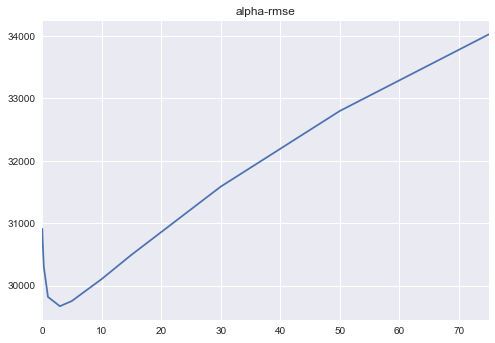

In [93]:
cv_ridge = pd.Series(cv_ridge,index = alphas)
cv_ridge.plot(title = "alpha-rmse")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [95]:
cv_ridge.min()

29669.710073355607

In [96]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)
rmse_cv(model_lasso).mean()

//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of

30860.24493064683

In [97]:
# Nice! The lasso performs even better so we'll just use this one to predict on the test set. 
# Another neat thing about the Lasso is that it does feature selection for you - setting coefficients of features it deems unimportant to zero. 
# Let's take a look at the coefficients:

In [98]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 264 variables and eliminated the other 24 variables


In [99]:
# Good job Lasso. One thing to note here however is that the features selected are not necessarily the "correct" ones - 
# especially since there are a lot of collinear features in this dataset. 
# One idea to try here is run Lasso a few times on boostrapped samples and see how stable the feature selection is.
# We can also take a look directly at what the most important coefficients are:

In [100]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

AttributeError: module 'matplotlib' has no attribute 'title'

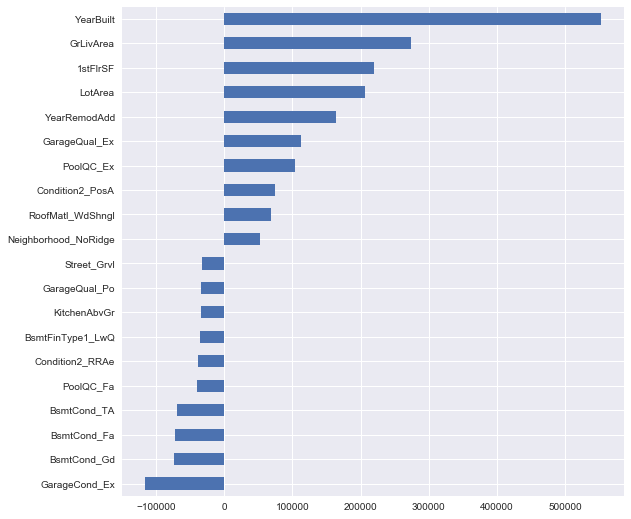

In [106]:
imp_coef.plot(kind = "barh", figsize = (9,9))
plt.title("Coefficients in the Lasso Model")

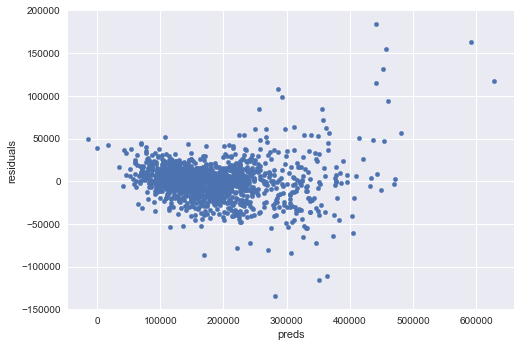

In [107]:
preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

In [108]:
# Read-in test dataset
test = pd.read_csv("test.csv")

In [110]:
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [112]:
model_lasso.predict(test)

ValueError: could not convert string to float: 'Normal'